# CS445 Final Project: Face Swapping

### Group Members:

Hongxiao Chen, Shuai Wei, Zhexuan Yin

### Motivation
The objective for this project is to be able to capture a facial expression from one image and put it on another person. The motivation for this project is that people may want to capture an expression from another person, and then be able to apply it to another image. By completing this project, we hope to learn how to capture facial expression and blend naturally onto another image. 

## Setup

In [61]:
import cv2
import dlib
import numpy as np
from matplotlib import pyplot as plt

## Part 1: Landmark & Triangulation source image

In [60]:
def extract_index_nparray(nparray):
    index = None
    for num in nparray[0]:
        index = num
        break
    return index

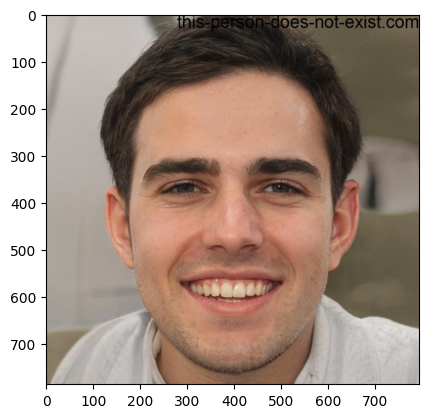

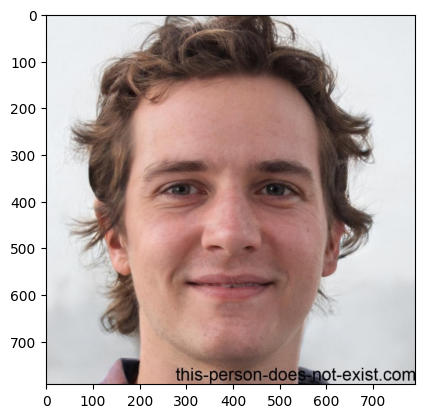

In [63]:
# Import
img = cv2.imread("images/test1.jpg")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img[:, :, [2, 1, 0]])

plt.figure()
img2 = cv2.imread("images/test2.jpg")
img2_gray= cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
plt.imshow(img2[:, :, [2, 1, 0]])

(H1, W1) = img_gray.shape
(H2, W2) = img2_gray.shape

In [64]:
mask = np.zeros_like(img_gray)
points_img = np.copy(img)
indexes_triangles = []
landmarks_points = []

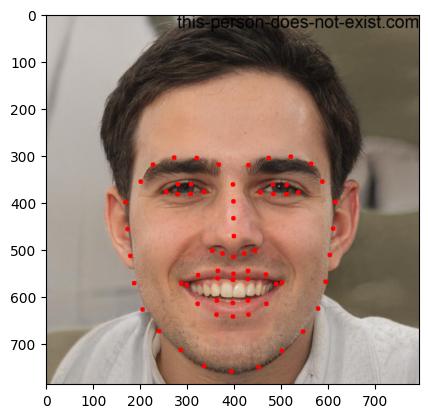

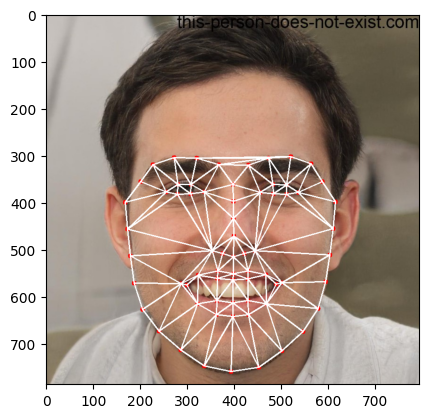

In [65]:
# Load from dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("utils/shape_predictor_68_face_landmarks.dat")

# Face 1
faces = detector(img_gray)
for face in faces:
  landmarks = predictor(img_gray, face)
  for n in range(0, 68):
    x = landmarks.part(n).x
    y = landmarks.part(n).y
    landmarks_points.append((x, y))
  
  points = np.array(landmarks_points, np.int32)
  for point in points:
    cv2.circle(points_img, tuple(point), 5, (0, 0, 255), -1)

  convexhull = cv2.convexHull(points)
  cv2.fillConvexPoly(mask, convexhull, 255)
  face_image_1 = cv2.bitwise_and(img, img, mask=mask)

  plt.figure()
  plt.imshow(points_img[:,:,[2,1,0]])

  # Delaunay triangulation
  triangles_img = np.copy(points_img)
  rect = cv2.boundingRect(convexhull)
  subdiv = cv2.Subdiv2D(rect)
  subdiv.insert(landmarks_points)
  triangles = subdiv.getTriangleList()
  triangles = np.array(triangles, dtype=np.int32)

  for t in triangles:
    pt1 = (t[0], t[1])
    pt2 = (t[2], t[3])
    pt3 = (t[4], t[5])


    index_pt1 = np.where((points == pt1).all(axis=1))
    index_pt1 = extract_index_nparray(index_pt1)

    index_pt2 = np.where((points == pt2).all(axis=1))
    index_pt2 = extract_index_nparray(index_pt2)

    index_pt3 = np.where((points == pt3).all(axis=1))
    index_pt3 = extract_index_nparray(index_pt3)

    if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
      triangle = [index_pt1, index_pt2, index_pt3]
      indexes_triangles.append(triangle)
  
  triangles = triangles.reshape(-1, 3, 2)
  cv2.polylines(triangles_img, triangles, True, (255, 255, 255), thickness=2)

  plt.figure()
  plt.imshow(triangles_img[:,:,[2,1,0]])

## Part 2: Triangulation destination image & Extract and warp triangles

In [67]:
mask2 = np.zeros_like(img2_gray)
points_img2 = np.copy(img2)
landmarks_points2 = []
convexhull2 = []

detector2 = dlib.get_frontal_face_detector()
predictor2 = dlib.shape_predictor("utils/shape_predictor_68_face_landmarks.dat")

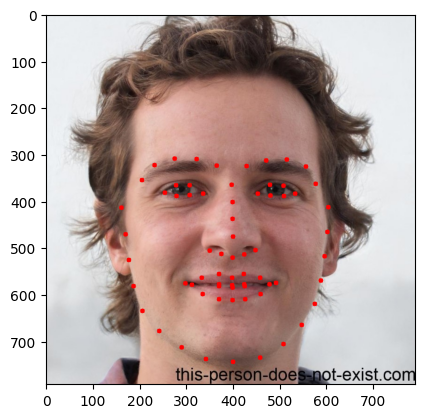

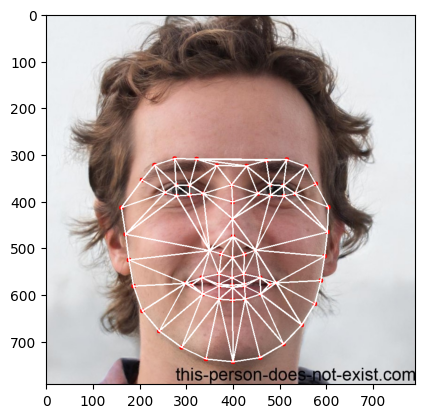

In [69]:
faces2 = detector2(img2_gray)
for face in faces2:
  landmarks = predictor2(img2_gray, face)
  landmarks_points2 = []
  for n in range(0, 68):
    x = landmarks.part(n).x
    y = landmarks.part(n).y
    landmarks_points2.append((x, y))
  
  points = np.array(landmarks_points2, np.int32)
  for point in points:
    cv2.circle(points_img2, tuple(point), 5, (0, 0, 255), -1)

  convexhull2 = cv2.convexHull(points)
  cv2.fillConvexPoly(mask2, convexhull2, 255)
  face_image_1 = cv2.bitwise_and(img2, img2, mask=mask2)

  plt.figure()
  plt.imshow(points_img2[:,:,[2,1,0]])

  # Delaunay triangulation
  triangles_img = np.copy(points_img2)
  rect = cv2.boundingRect(convexhull2)
  subdiv = cv2.Subdiv2D(rect)
  subdiv.insert(landmarks_points2)
  triangles = subdiv.getTriangleList()
  triangles = np.array(triangles, dtype=np.int32)
  triangles = triangles.reshape(-1, 3, 2)
  cv2.polylines(triangles_img, triangles, True, (255, 255, 255), thickness=2)

  plt.figure()
  plt.imshow(triangles_img[:,:,[2,1,0]])

In [70]:
img2_new_face = np.zeros(img2.shape, np.uint8)

for triangle_index in indexes_triangles:
  # Triangulation of the first face
  tr1_pt1 = landmarks_points[triangle_index[0]]
  tr1_pt2 = landmarks_points[triangle_index[1]]
  tr1_pt3 = landmarks_points[triangle_index[2]]
  triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)

  cropped_tr1_mask = np.zeros((H1, W1), np.uint8)
  
  cv2.fillConvexPoly(cropped_tr1_mask, triangle1, 255)

  # Triangulation of second face
  tr2_pt1 = landmarks_points2[triangle_index[0]]
  tr2_pt2 = landmarks_points2[triangle_index[1]]
  tr2_pt3 = landmarks_points2[triangle_index[2]]
  triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)

  cropped_tr2_mask = np.zeros((H2, W2), np.uint8)

  cv2.fillConvexPoly(cropped_tr2_mask, triangle2, 255)

  # Warp triangles
  triangle1 = np.float32(triangle1)
  triangle2 = np.float32(triangle2)
  M = cv2.getAffineTransform(triangle1, triangle2)
  warped_img_part = cv2.warpAffine(img, M, (W2, H2))
  warped_img_part = cv2.bitwise_and(warped_img_part, warped_img_part, mask=cropped_tr2_mask)

  # Remove the overlap part of newly added region
  overlap_mask = cv2.bitwise_and(img2_new_face, warped_img_part)
  warped_img_part = cv2.bitwise_xor(warped_img_part, overlap_mask)
  # Building the destination face
  img2_new_face = cv2.add(img2_new_face, warped_img_part)


## Part 3: Link the warped triangles together & Replace the face on the destination image

In [71]:
# Face swapped (putting 1st face into 2nd face)
img2_face_mask = np.zeros_like(img2_gray)
img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)
img2_face_mask = cv2.bitwise_not(img2_head_mask)


img2_head_noface = cv2.bitwise_and(img2, img2, mask=img2_face_mask)
result = cv2.add(img2_head_noface, img2_new_face)

(x, y, w, h) = cv2.boundingRect(convexhull2)
center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))

seamlessclone = cv2.seamlessClone(result, img2, img2_head_mask, center_face2, cv2.NORMAL_CLONE)

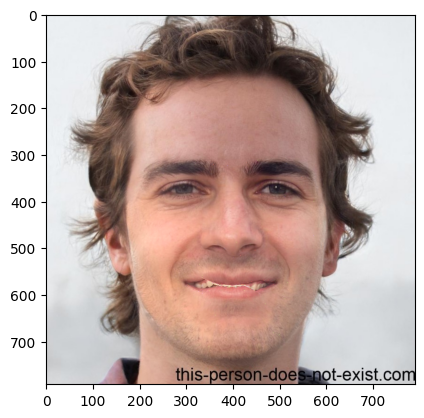

In [72]:
plt.figure()
plt.imshow(seamlessclone[:,:,[2,1,0]])